In [121]:
drive.flush_and_unmount()

In [1]:
from google.colab import drive
# drive.flush_and_unmount()
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
#Data Fetching
# !pip install opencv-contrib-python
from IPython.display import clear_output
!unzip "/content/drive/MyDrive/Job Section/Total Images.zip" -d "/content/drive/MyDrive/Job Section/"
clear_output()

In [3]:
!unzip "/content/drive/MyDrive/Job Section/Total GT.zip" -d "/content/drive/MyDrive/Job Section/"
clear_output()

In [4]:
#Useful imports
from tensorflow.keras.layers.experimental.preprocessing import StringLookup
from tensorflow import keras

import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import os
import cv2 as cv

np.random.seed(42)
tf.random.set_seed(42)

In [5]:
# get names of files
filenames_img=sorted(os.listdir('/content/drive/MyDrive/Job Section/Total Images'))
filenames_gt=sorted(os.listdir('/content/drive/MyDrive/Job Section/Total GT'))

filenames_imgsplit = []
for filename in filenames_img:
    filename = filename.replace('.tif', '')
    filename = filename.replace('.jpg', '')
    filename = filename.replace('.jpeg', '')
    filenames_imgsplit.append(filename)

filenames_gtsplit=[filename.replace('.txt', '') for filename in filenames_gt]
print(len(filenames_imgsplit))
print(len(filenames_gtsplit))

5161
5161


In [6]:
#train test validate splitting
split_idx = int(0.8 * len(filenames_imgsplit))
train_samples = filenames_img[:split_idx]
train_samples_split = filenames_imgsplit[:split_idx]
test_samples = filenames_img[split_idx:]
test_samples_split = filenames_imgsplit[split_idx:]

val_split_idx = int(0.5 * len(test_samples))
validation_samples = test_samples[:val_split_idx]
validation_samples_split = test_samples_split[:val_split_idx]
test_samples = test_samples[val_split_idx:]
test_samples_split = test_samples_split[val_split_idx:]

assert len(filenames_imgsplit) == len(train_samples) + len(validation_samples) + len(
    test_samples
)

print(f"Total training samples: {len(train_samples)}")
print(f"Total validation samples: {len(validation_samples)}")
print(f"Total test samples: {len(test_samples)}")
print(f'Example from training dataset {train_samples_split[0]}')

Total training samples: 4128
Total validation samples: 516
Total test samples: 517
Example from training dataset AHTD3A0003_Para1_1_word1


In [7]:
#get label_paths and labels_data as lists
base_path='/content/drive/MyDrive/Job Section/'
base_image_path = os.path.join(base_path, "Total Images/")
base_GT_path = os.path.join(base_path, "Total GT/")

def get_image_paths_and_labels(filenames_img, filenames_imgsplit):
    paths = []
    labels = []
    for i in range(len(filenames_imgsplit)):
        img_path = os.path.join(
            base_image_path,  filenames_img[i]
        )
        if os.path.getsize(img_path):
            paths.append(img_path)
            label_path = os.path.join(
            base_GT_path,  filenames_imgsplit[i]+'.txt'
        )
        label_file = open(label_path, "r")
        labels.append(label_file.read())

    return paths, labels

train_img_paths, train_labels = get_image_paths_and_labels(train_samples, train_samples_split)
validation_img_paths, validation_labels = get_image_paths_and_labels(validation_samples, validation_samples_split)
test_img_paths, test_labels = get_image_paths_and_labels(test_samples, test_samples_split)

In [8]:
# Find maximum length and the size of the vocabulary in the training data.
train_labels_cleaned = []
characters = set()
max_len = 0

for label in train_labels:
    label = label.split(" ")[-1].strip()
    for char in label:
        characters.add(char)

    max_len = max(max_len, len(label))
    train_labels_cleaned.append(label)

print("Maximum length: ", max_len)
print("Vocab size: ", len(characters))

# Check some label samples.
train_labels_cleaned[:10]

Maximum length:  7
Vocab size:  39


['أت', 'ظافر', 'يق', 'را', 'ي', 'لؤ', 'بن', 'رؤوف', 'بصحبة', 'م']

In [9]:
# same cleaning for validation and test labels
def clean_labels(labels):
    cleaned_labels = []
    for label in labels:
        label = label.split(" ")[-1].strip()
        cleaned_labels.append(label)
    return cleaned_labels


validation_labels_cleaned = clean_labels(validation_labels)
test_labels_cleaned = clean_labels(test_labels)


In [10]:
print(characters)

{':', 'غ', '.', 'ز', 'ص', 'ض', 'ت', 'أ', '،', 'ب', 'ذ', 'ن', 'ة', 'ء', 'ط', 'ا', 'ف', 'ل', 'د', 'ي', 'ئ', 'م', 'ث', 'س', 'ؤ', 'آ', 'ر', 'ظ', 'ك', 'خ', 'ع', 'ق', 'ج', 'إ', 'ه', 'ش', 'ٍ', 'ح', 'و'}


In [11]:
# Mapping for RNN
AUTOTUNE = tf.data.AUTOTUNE

# Mapping characters to integers.
char_to_num = StringLookup(vocabulary=list(characters), mask_token=None)

# Mapping integers back to original characters.
num_to_char = StringLookup(
    vocabulary=char_to_num.get_vocabulary(), mask_token=None, invert=True
)

In [12]:
# resize input image
def distortion_free_resize(image, img_size):
    w, h = img_size
    image = tf.image.resize(image, size=(h, w), preserve_aspect_ratio=True)

    # Check tha amount of padding needed to be done.
    pad_height = h - tf.shape(image)[0]
    pad_width = w - tf.shape(image)[1]

    # Only necessary if you want to do same amount of padding on both sides.
    if pad_height % 2 != 0:
        height = pad_height // 2
        pad_height_top = height + 1
        pad_height_bottom = height
    else:
        pad_height_top = pad_height_bottom = pad_height // 2

    if pad_width % 2 != 0:
        width = pad_width // 2
        pad_width_left = width + 1
        pad_width_right = width
    else:
        pad_width_left = pad_width_right = pad_width // 2

    image = tf.pad(
        image,
        paddings=[
            [pad_height_top, pad_height_bottom],
            [pad_width_left, pad_width_right],
            [0, 0],
        ],
    )

    image = tf.transpose(image, perm=[1, 0, 2])
    image = tf.image.flip_left_right(image)
    return image

In [13]:
print(train_labels_cleaned)

['أت', 'ظافر', 'يق', 'را', 'ي', 'لؤ', 'بن', 'رؤوف', 'بصحبة', 'م', 'ضرغا', 'بد', 'مظفر', 'نوح', 'ذهب', '.', 'للحج', 'عفيف', 'ن', 'خاز', 'وهلال', 'عطعوط', 'وهو', 'و', 'طفنا', 'لنا', 'وصو', 'عند', '.', 'يلبي', 'آخر', 'ثر', 'إ', 'حاج', 'في', 'جاري', 'كان', '.', 'شيخ', 'مع', 'سعينا', '.', 'رايق', 'ي', 'لؤ', 'بن', '.', 'رؤوف', 'بصحبة', 'م', 'ضرغا', 'مظفر', 'للحج', 'نوح', 'هب', 'ذ', 'عفيف', 'خازن', 'ل', 'وهلا', 'عطعوط', 'فر', 'ظا', 'الخيمة', 'وصولنا', 'عند', '.', 'يلبي', 'آخر', 'إ', 'حاج', 'لحجيج', 'ا', 'قوافل', 'في', 'أت', 'بد', 'جاري', 'كان', '.', 'شيخ', 'مع', 'وسعينا', 'طفنا', '.', 'دراق', '،', 'مشمش', ':', 'لنص', 'ا', 'ا', 'لهذ', 'نسر', '،', 'بث', '،', 'ناء', '،', 'غيظ', '،', '.', 'نسر', '،', 'بث', '،', 'ء', 'نا', '،', 'غيظ', 'ط', 'و', 'ؤ', 'ر', '.', '.', 'بصحبة', 'م', 'غا', 'ضر', 'عطعو', 'مظفر', 'ح', 'نو', 'هب', 'ذ', 'ظافر', 'يق', 'ا', 'ر', 'ء', 'لؤ', 'بن', 'ت', 'أ', 'بد', '.', 'للحج', 'عفيف', 'ن', 'خاز', 'ل', 'هلا', 'إ', 'ج', 'حا', 'لحجيج', 'أ', 'فل', 'ا', 'قو', 'سعينا', 'و', 'طفنا', 'ل

In [14]:
batch_size = 64
padding_token = 99
image_width = 64
image_height = 32


def preprocess_image(image_path, img_size=(image_width, image_height)):
    # get image -> resize & normalize
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, 0)
    image = distortion_free_resize(image, img_size)
    image = tf.cast(image, tf.float32) / 255.0
    return image


def vectorize_label(label):
    # to padding all labels with same size
    print(label)
    label = char_to_num(tf.strings.unicode_split(label, input_encoding="UTF-8"))
    length = tf.shape(label)[0]
    pad_amount = max_len - length
    label = tf.pad(label, paddings=[[0, pad_amount]], constant_values=padding_token)
    return label
    
label=vectorize_label(train_labels_cleaned[0])
print(label)
indices = tf.gather(label, tf.where(tf.math.not_equal(label, padding_token)))
label = tf.strings.reduce_join(num_to_char(indices))
label = label.numpy().decode("utf-8")
print(label)

def process_images_labels(image_path, label):
    image = preprocess_image(image_path)
    label = vectorize_label(label)
    return {"image": image, "label": label}


def prepare_dataset(image_paths, labels):
    dataset = tf.data.Dataset.from_tensor_slices((image_paths, labels)).map(
        process_images_labels, num_parallel_calls=AUTOTUNE
    )
    return dataset.batch(batch_size).cache().prefetch(AUTOTUNE)

أت
tf.Tensor([ 8  7 99 99 99 99 99], shape=(7,), dtype=int64)
أت


In [15]:
train_ds = prepare_dataset(train_img_paths, train_labels_cleaned)
validation_ds = prepare_dataset(validation_img_paths, validation_labels_cleaned)
test_ds = prepare_dataset(test_img_paths, test_labels_cleaned)

Tensor("args_1:0", shape=(), dtype=string)
Tensor("args_1:0", shape=(), dtype=string)
Tensor("args_1:0", shape=(), dtype=string)


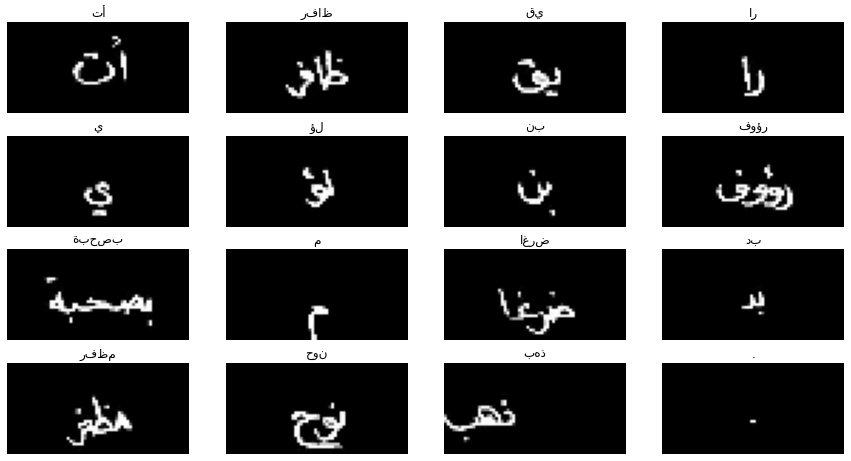

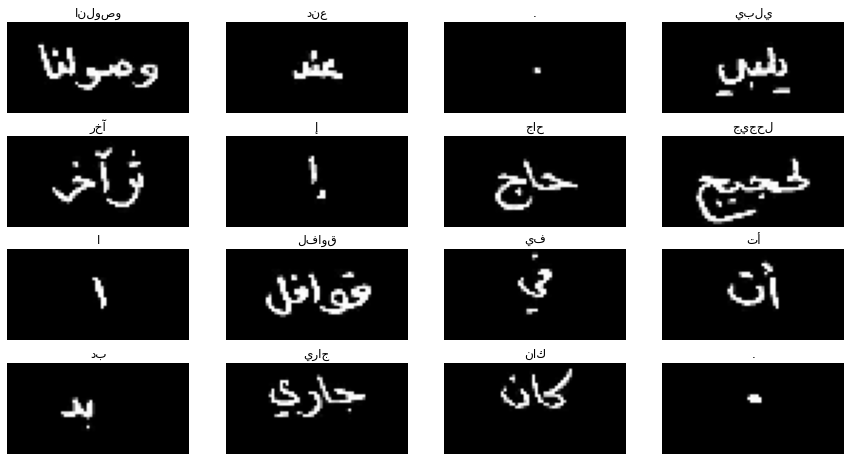

In [16]:
# visualize train dataset and it's label
for data in train_ds.take(2):
    images, labels = data["image"], data["label"]

    _, ax = plt.subplots(4, 4, figsize=(15, 8))

    for i in range(16):
        img = images[i]
        img = tf.image.flip_left_right(img)
        img = tf.transpose(img, perm=[1, 0, 2])
        img = (img * 255.0).numpy().clip(0, 255).astype(np.uint8)
        img = img[:, :, 0]

        # Gather indices where label!= padding_token.
        label = labels[i]
        indices = tf.gather(label, tf.where(tf.math.not_equal(label, padding_token)))
        # Convert to string.
        label = tf.strings.reduce_join(num_to_char(indices))
        label = label.numpy().decode("utf-8")

        ax[i // 4, i % 4].imshow(img, cmap="gray")
        ax[i // 4, i % 4].set_title(label[::-1])
        ax[i // 4, i % 4].axis("off")


plt.show()

In [17]:
# CTC loss: to remove repeatition and blanks + Model is CRNN: To Capture complex features of KUFFIC arabic language
class CTCLayer(keras.layers.Layer):
    def __init__(self, name=None):
        super().__init__(name=name)
        self.loss_fn = keras.backend.ctc_batch_cost

    def call(self, y_true, y_pred):
        batch_len = tf.cast(tf.shape(y_true)[0], dtype="int64")
        input_length = tf.cast(tf.shape(y_pred)[1], dtype="int64")
        label_length = tf.cast(tf.shape(y_true)[1], dtype="int64")

        input_length = input_length * tf.ones(shape=(batch_len, 1), dtype="int64")
        label_length = label_length * tf.ones(shape=(batch_len, 1), dtype="int64")
        loss = self.loss_fn(y_true, y_pred, input_length, label_length)
        self.add_loss(loss)

        # At test time, just return the computed predictions.
        return y_pred


def build_model():
    # Inputs to the model
    input_img = keras.Input(shape=(image_width, image_height, 1), name="image")
    labels = keras.layers.Input(name="label", shape=(None,)) # 7 or None?

    # First conv block.
    x = keras.layers.Conv2D(
        32,
        (3, 3),
        activation="relu",
        kernel_initializer="he_normal",
        padding="same",
        name="Conv1",
    )(input_img)
    x = keras.layers.MaxPooling2D((2, 2), name="pool1")(x)
    x= keras.layers.BatchNormalization()(x)
    new_shape = ((image_width // 2), (image_height // 2) * 32) 
    x = keras.layers.Reshape(target_shape=new_shape, name="reshape")(x)
    x = keras.layers.Dense(16, activation="relu", name="dense2")(x)
    x= keras.layers.BatchNormalization()(x)
    x = keras.layers.Bidirectional(
        keras.layers.LSTM(128, return_sequences=True, dropout=0.35))(x)
    x = keras.layers.Dense(
        len(char_to_num.get_vocabulary()) + 2, activation="softmax", name="dense3"
    )(x) # len(char_to_num.get_vocabulary()) + 2 = 42
    output = CTCLayer(name="ctc_loss")(labels, x)

    # Define the model.
    model = keras.models.Model(
        inputs=[input_img, labels], outputs=output, name="handwriting_recognizer"
    )
    # Optimizer.
    lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.0001,
    decay_steps=10000,
    decay_rate=0.9)
    opt = keras.optimizers.Adam(learning_rate=lr_schedule)
    # Compile the model and return.
    model.compile(optimizer=opt)
    return model


# Get the model.
model = build_model()
model.summary()

Model: "handwriting_recognizer"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 image (InputLayer)             [(None, 64, 32, 1)]  0           []                               
                                                                                                  
 Conv1 (Conv2D)                 (None, 64, 32, 32)   320         ['image[0][0]']                  
                                                                                                  
 pool1 (MaxPooling2D)           (None, 32, 16, 32)   0           ['Conv1[0][0]']                  
                                                                                                  
 batch_normalization (BatchNorm  (None, 32, 16, 32)  128         ['pool1[0][0]']                  
 alization)                                                                  

In [18]:
validation_images = []
validation_labels = []

for batch in validation_ds:
    validation_images.append(batch["image"])
    validation_labels.append(batch["label"])

In [19]:
# callback function calculate CTC loss

def calculate_edit_distance(labels, predictions):
    # Get a single batch and convert its labels to sparse tensors.
    saprse_labels = tf.sparse.from_dense(labels)

    # Make predictions and convert them to sparse tensors.
    input_len = np.ones(predictions.shape[0]) * predictions.shape[1]

    predictions_decoded = keras.backend.ctc_decode(
        
        predictions, input_length=input_len, greedy=False, beam_width=100,
    )[0][0][:, :max_len]
    sparse_predictions =tf.sparse.from_dense(predictions_decoded)
    
    # Compute individual edit distances and average them out.
    edit_distances = tf.edit_distance(
        sparse_predictions, saprse_labels, normalize=False
    )
    return tf.reduce_mean(edit_distances)


class EditDistanceCallback(keras.callbacks.Callback):
    def __init__(self, pred_model):
        super().__init__()
        self.prediction_model = pred_model

    def on_epoch_end(self, epoch, logs=None):
        edit_distances = []

        for i in range(len(validation_images)):
            labels = validation_labels[i]
            predictions = self.prediction_model.predict(validation_images[i])
            edit_distances.append(calculate_edit_distance(labels, predictions).numpy())

        print(
            f"Mean edit distance for epoch {epoch + 1}: {np.mean(edit_distances):.4f}"
        )

In [20]:
# Training
epochs = 450  # To get good results this should be at least 50.

model = build_model()
prediction_model = keras.models.Model(
    model.get_layer(name="image").input, model.get_layer(name="dense3").output
)
edit_distance_callback = EditDistanceCallback(prediction_model)

stopping=tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    min_delta=0,
    patience=3,
    verbose=0,
    mode="auto",
    baseline=None,
    restore_best_weights=False,
)

# Train the model.
history = model.fit(
    train_ds,
    validation_data=validation_ds,
    epochs=epochs,
    callbacks=[edit_distance_callback],
    shuffle=True
)

#add early stopping mechanism

Streaming output truncated to the last 5000 lines.
1/1 [==============================] - 0s 25ms/step
Mean edit distance for epoch 34: 6.9253
65/65 [==============================] - 17s 259ms/step - loss: 8.1058 - val_loss: 8.5831
Epoch 35/450
1/1 [==============================] - 0s 36ms/step
Mean edit distance for epoch 35: 6.9219
65/65 [==============================] - 18s 280ms/step - loss: 8.0915 - val_loss: 8.5647
Epoch 36/450
1/1 [==============================] - 0s 30ms/step
Mean edit distance for epoch 36: 6.9271
65/65 [==============================] - 17s 260ms/step - loss: 8.0804 - val_loss: 8.5576
Epoch 37/450
1/1 [==============================] - 0s 27ms/step
Mean edit distance for epoch 37: 6.9253
65/65 [==============================] - 17s 257ms/step - loss: 8.0687 - val_loss: 8.5414
Epoch 38/450
1/1 [==============================] - 0s 39ms/step
Mean edit distance for epoch 38: 6.9236
65/65 [==============================] - 17s 270ms/step - loss: 8.0563 - val_

In [21]:
# A utility function to decode the output of the network into text to see it.
def decode_batch_predictions(pred):
    input_len = np.ones(pred.shape[0]) * pred.shape[1]
    # Use greedy search. For complex tasks, you can use beam search.
    results = keras.backend.ctc_decode(pred, input_length=input_len, greedy=True)[0][0][
        :, :max_len
    ]
    # Iterate over the results and get back the text.
    output_text = []
    for res in results:
        res = tf.gather(res, tf.where(tf.math.not_equal(res, -1)))
        res = tf.strings.reduce_join(num_to_char(res)).numpy().decode("utf-8")
        output_text.append(res)
    print(output_text)
    return output_text

2/2 [==============================] - 0s 32ms/step
['آت', 'ظار', 'يق', 'را', 'ي', 'ل', 'بن', 'وؤف', 'بصبة', 'م', 'غرغ', 'ب', 'مل', 'نح', 'ذ', '.', 'للح', 'فيف', 'ذ', 'خا', 'وهول', 'عطعط', 'وه', 'و', 'فطنا', 'لاا', 'ص', 'عن', '.', 'يلبي', 'آخر', 'ثر', 'إ', 'حاج', 'ي', 'بابي', 'با', '.', 'شيخ', 'ع', 'سعن', '.', 'ا', 'ي', 'لؤ', 'ن', '.', 'رؤوف', 'بصححبة', 'م', 'ضرغ', 'مظفر', 'لحج', 'نوح', 'هب', 'ذ', 'عي', 'ان', 'ل', 'هل', 'عطعط', 'ف', 'ظا', 'الحية']
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False


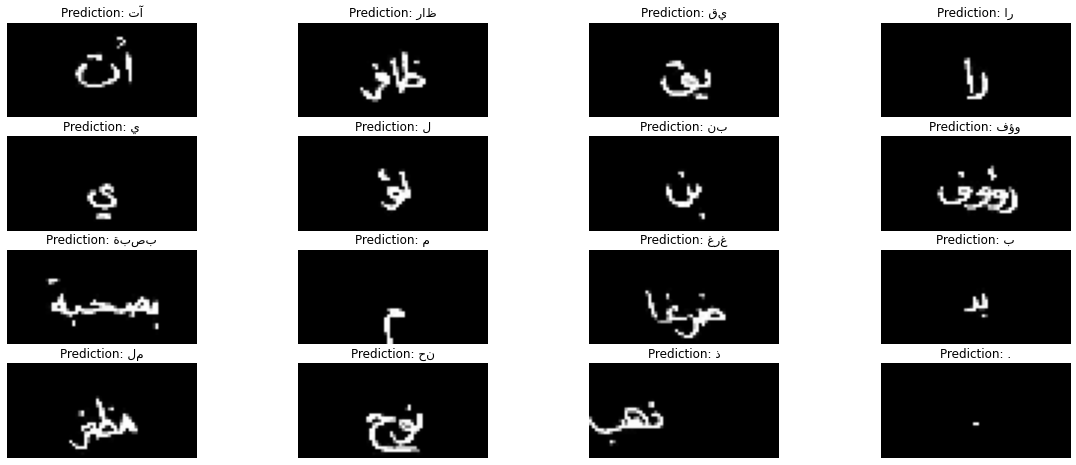

In [27]:
# accuracy on train cases.
#  Let's check results on some test samples.
for batch in train_ds.take(1):
    batch_images = batch["image"]
    _, ax = plt.subplots(4, 4, figsize=(20, 8))

    preds = prediction_model.predict(batch_images)
    pred_texts = decode_batch_predictions(preds)

    for i in range(16):
        img = batch_images[i]
        img = tf.image.flip_left_right(img)
        img = tf.transpose(img, perm=[1, 0, 2])
        img = (img * 255.0).numpy().clip(0, 255).astype(np.uint8)
        img = img[:, :, 0]

        title = f"Prediction: {pred_texts[i][::-1]}" #label[::-1]
        print(pred_texts[i]=='')
        ax[i // 4, i % 4].imshow(img, cmap="gray")
        ax[i // 4, i % 4].set_title(title)
        ax[i // 4, i % 4].axis("off")

plt.show()

2/2 [==============================] - 0s 32ms/step
['أ', 'م', 'بكلمم', 'ذ', 'أا', '،', 'ن', 'سون', 'أ', 'بن', 'ر', 'ج', ':', 'د', 'كلما', 'ا', 'ة', 'ذ', 'نا', 'تع', 'هل', '،', 'لحج', 'سر', 'ا', 'ف', 'كا', 'أ', 'ه', 'كا', '،', 'ت', 'ب', 'ت', '.', '،', 'ن', 'ة', 'ا', 'الض', 'ا', 'ل', 'تا', 'ا', '.', 'س', 'را', 'د', '،', 'شم', '،', 'لضص', 'فطا', 'لالة', 'ب', 'نر', 'ملماا', '،', 'ب', '،', 'ر', 'نا', '،', 'ي']
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False


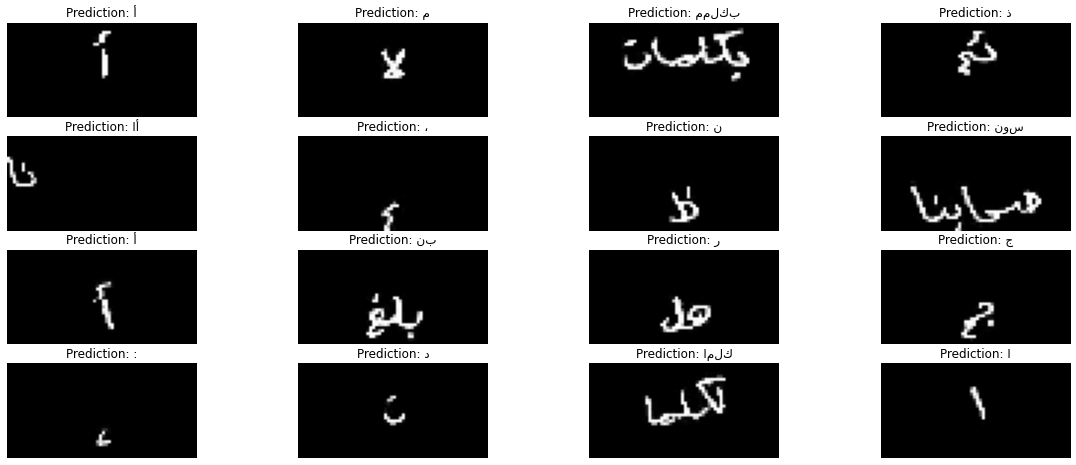

In [28]:
# accuracy on test cases never seen by model before.
#  Let's check results on some test samples.
for batch in test_ds.take(1):
    batch_images = batch["image"]
    _, ax = plt.subplots(4, 4, figsize=(20, 8))

    preds = prediction_model.predict(batch_images)
    pred_texts = decode_batch_predictions(preds)

    for i in range(16):
        img = batch_images[i]
        img = tf.image.flip_left_right(img)
        img = tf.transpose(img, perm=[1, 0, 2])
        img = (img * 255.0).numpy().clip(0, 255).astype(np.uint8)
        img = img[:, :, 0]

        title = f"Prediction: {pred_texts[i][::-1]}"
        print(pred_texts[i]=='')
        ax[i // 4, i % 4].imshow(img, cmap="gray")
        ax[i // 4, i % 4].set_title(title)
        ax[i // 4, i % 4].axis("off")

plt.show()

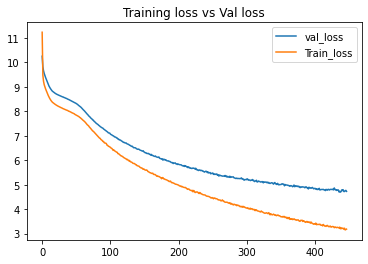

In [24]:
# Train-Validation Loss curve
plt.plot(history.history['val_loss'][2:len(history.history['val_loss'])-1])
plt.plot(history.history['loss'][2:len(history.history['loss'])-1])
plt.legend(["val_loss", "Train_loss"], loc ="upper right")
plt.title("Training loss vs Val loss")
plt.show()

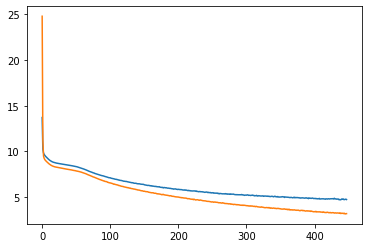

In [25]:
plt.plot(history.history['val_loss'][1:len(history.history['val_loss'])-1])
plt.plot(history.history['loss'][1:len(history.history['loss'])-1])

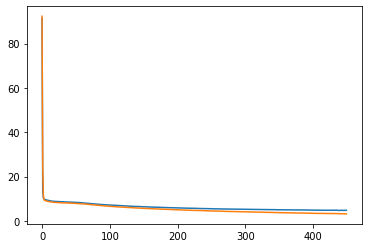

In [26]:
plt.plot(history.history['val_loss'])
plt.plot(history.history['loss'])

In [29]:
# save model - 2 approachs

# 1st approach using saveModel (store as graph execution)

# !mkdir -p saved_model
# prediction_model.save('saved_model/my_model')
# new_model = tf.keras.models.load_model('saved_model/my_model')
# # Check its architecture
# new_model.summary()

# 2nd apporach using HDF5 files (store model as object configs):
prediction_model.save('my_model.h5')
arabic_handwritten_recognation_model = tf.keras.models.load_model('my_model.h5')
# Check its architecture
arabic_handwritten_recognation_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 image (InputLayer)          [(None, 64, 32, 1)]       0         
                                                                 
 Conv1 (Conv2D)              (None, 64, 32, 32)        320       
                                                                 
 pool1 (MaxPooling2D)        (None, 32, 16, 32)        0         
                                                                 
 batch_normalization_2 (Batc  (None, 32, 16, 32)       128       
 hNormalization)                                                 
                                                                 
 reshape (Reshape)           (None, 32, 512)           0         
                                                                 
 dense2 (Dense)              (None, 32, 16)            8208      
                                                             